# Network spiking activity

Report on the activity of the spiking network for a training of 60s.

In [1]:
import os
import pprint

if os.path.exists("/home/alphat"):
    os.chdir("/home/alphat/neuvisys-analysis/src")
    home = "/home/alphat/"
else:
    os.chdir("/home/thomas/neuvisys-analysis/src")
    home = "/home/thomas/"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 28
MEDIUM_SIZE = 32
BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE)     # fontsize of the axes title, fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [2]:
def spike_plot(spike_train):
    plt.figure(figsize=(16, 6))
    plt.xlabel("time (µs)")
    plt.ylabel("neurons")

    plt.eventplot(spike_train[spike_train != 0])

def spike_plots_inhibited_neurons(spinet, layer, neuron_id):
    plt.figure(figsize=(16, 6))
    plt.xlabel("time (µs)")
    plt.ylabel("neurons")

    indices = spinet.neurons[layer][neuron_id].params["inhibition_connections"]
    colors1 = ["C{}".format(i) for i in range(len(indices) + 1)]

    eveplot = []
    for i in np.sort(indices + [neuron_id]):
        eveplot.append(spinet.spikes[layer][i][spinet.spikes[layer][i] != 0])

    plt.eventplot(eveplot, colors=colors1)

def plot_isi_histogram(spike_train):
    isi = np.diff(spike_train) / 1000
    isi = isi[isi > 0]

    fig = plt.figure(figsize=(16, 6))
    plt.title("Neuron ISI histogram")
    plt.xlabel("interspike interval (ms)")
    plt.hist(isi, bins=np.arange(0, 700, 25))
    return isi, fig

def spike_rate_histogram(layer_spike_train):
    spike_count = np.count_nonzero(layer_spike_train, axis=1)
    plt.figure(figsize=(12, 4))
    plt.title("Spike rate histogram")
    plt.hist(spike_count / (np.max(layer_spike_train) * 1e-6))
    plt.xlabel("spike / s")
    plt.show()

def spike_rate_variation(layer_spike_train, timebin):
    signal = []
    tstep = np.arange(0, np.max(layer_spike_train), timebin)
    for i in range(tstep.size-1):
        signal.append(np.sum((layer_spike_train > tstep[i]) & (layer_spike_train < tstep[i+1])))
    return np.array(signal), tstep

def plot_spike_rate_variation(layer_spike_train, timebin=1000000):#1sec
    signal, tstep = spike_rate_variation(layer_spike_train, timebin)
    plt.figure(figsize=(40, 8))
    plt.title("Spike rate variation (time bin = " + str(timebin / 1e3) + "ms)")
    plt.plot(tstep[:-1] / 1e6, signal)
    plt.xlabel("time (s)")
    plt.ylabel("number of spikes")
    plt.show()

In [3]:
from spiking_network.network.neuvisys import SpikingNetwork

network_path = home + "neuvisys-dv/configuration/network/"
spinet = SpikingNetwork(network_path)

## Network training information

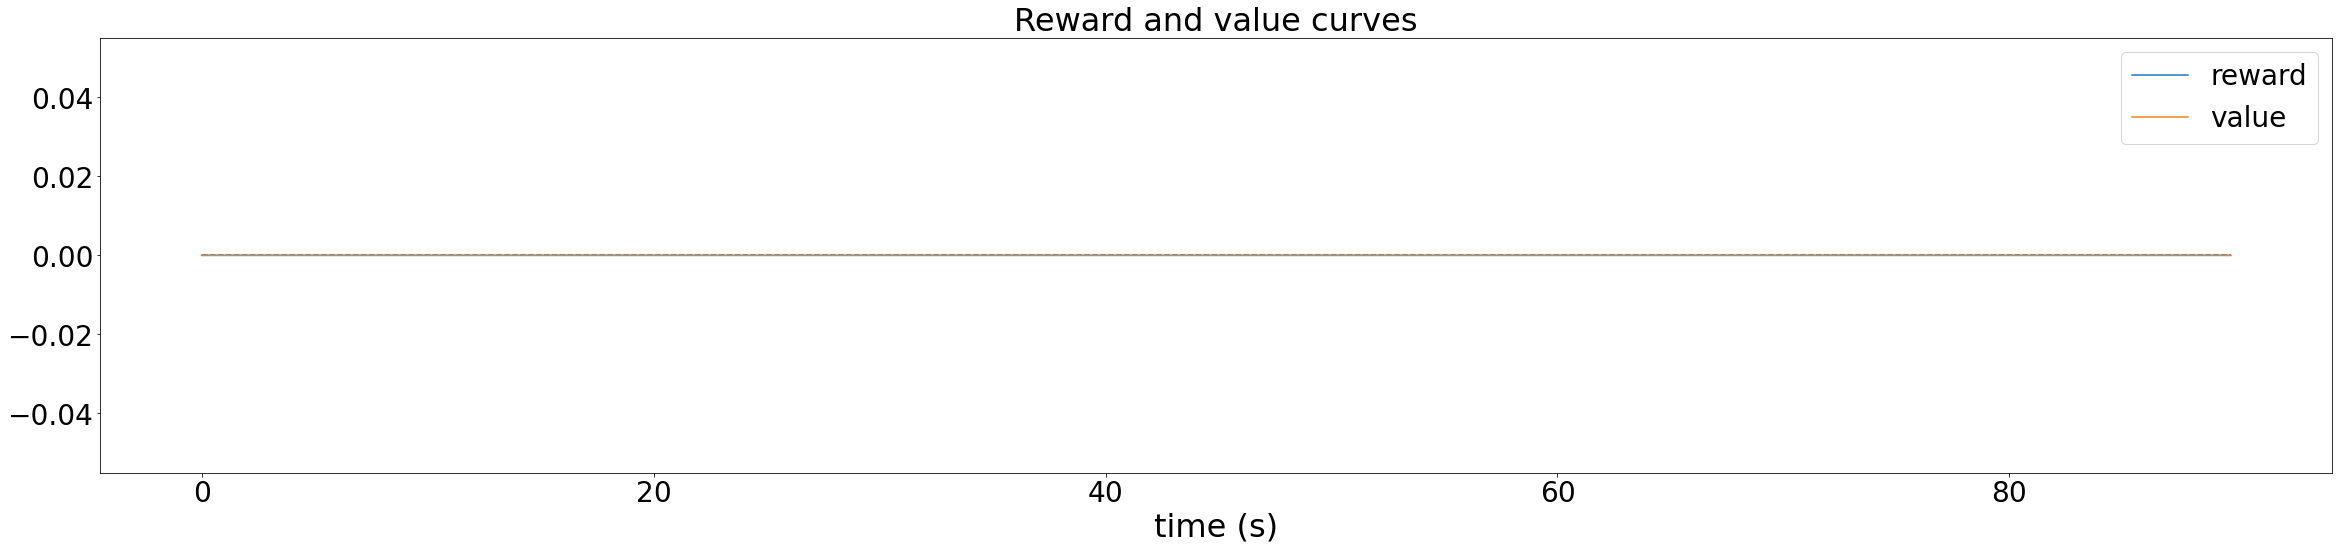

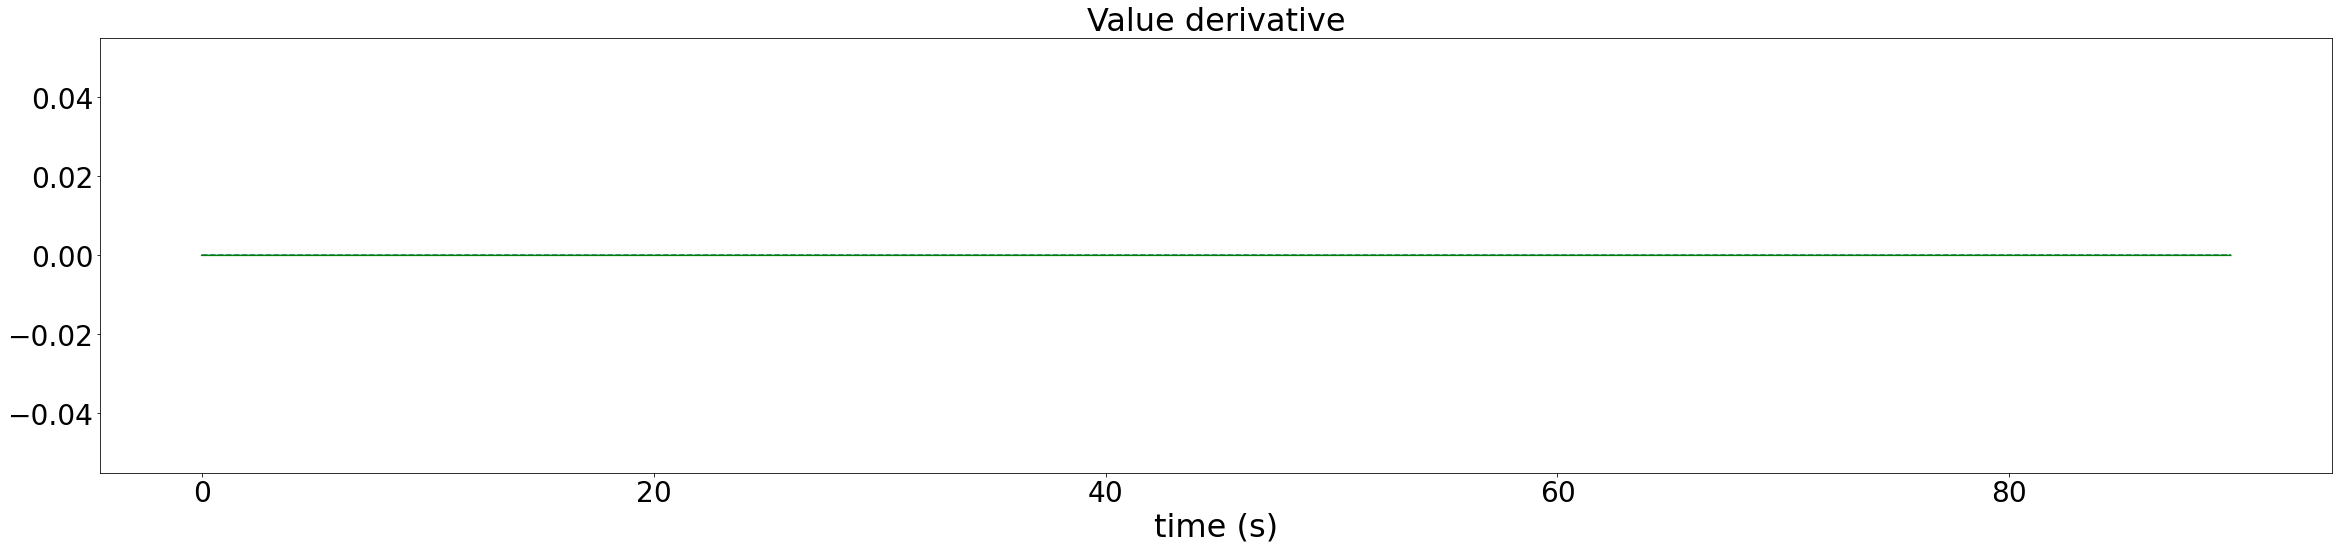

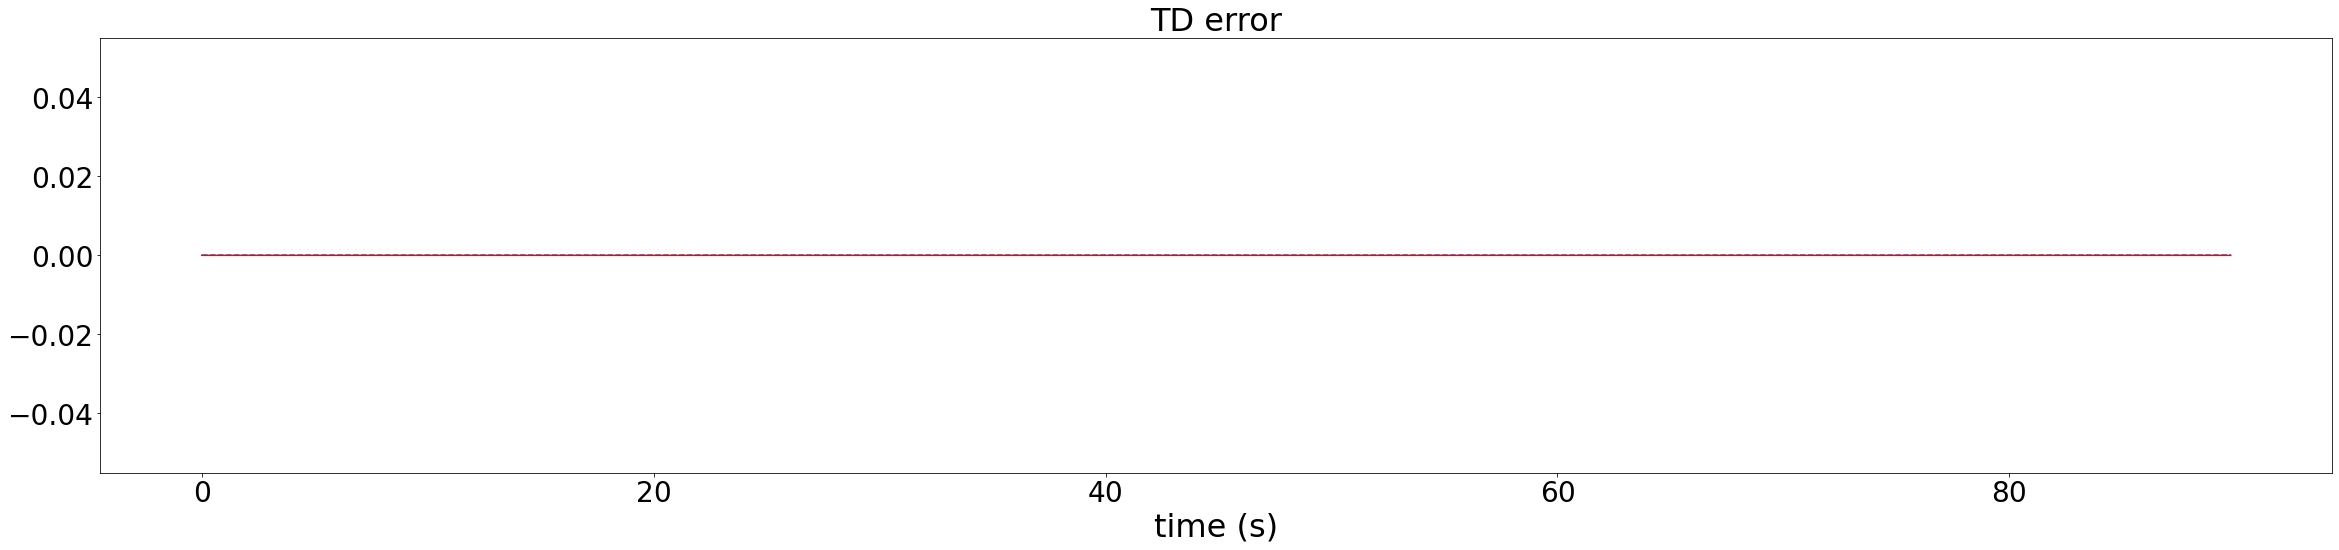

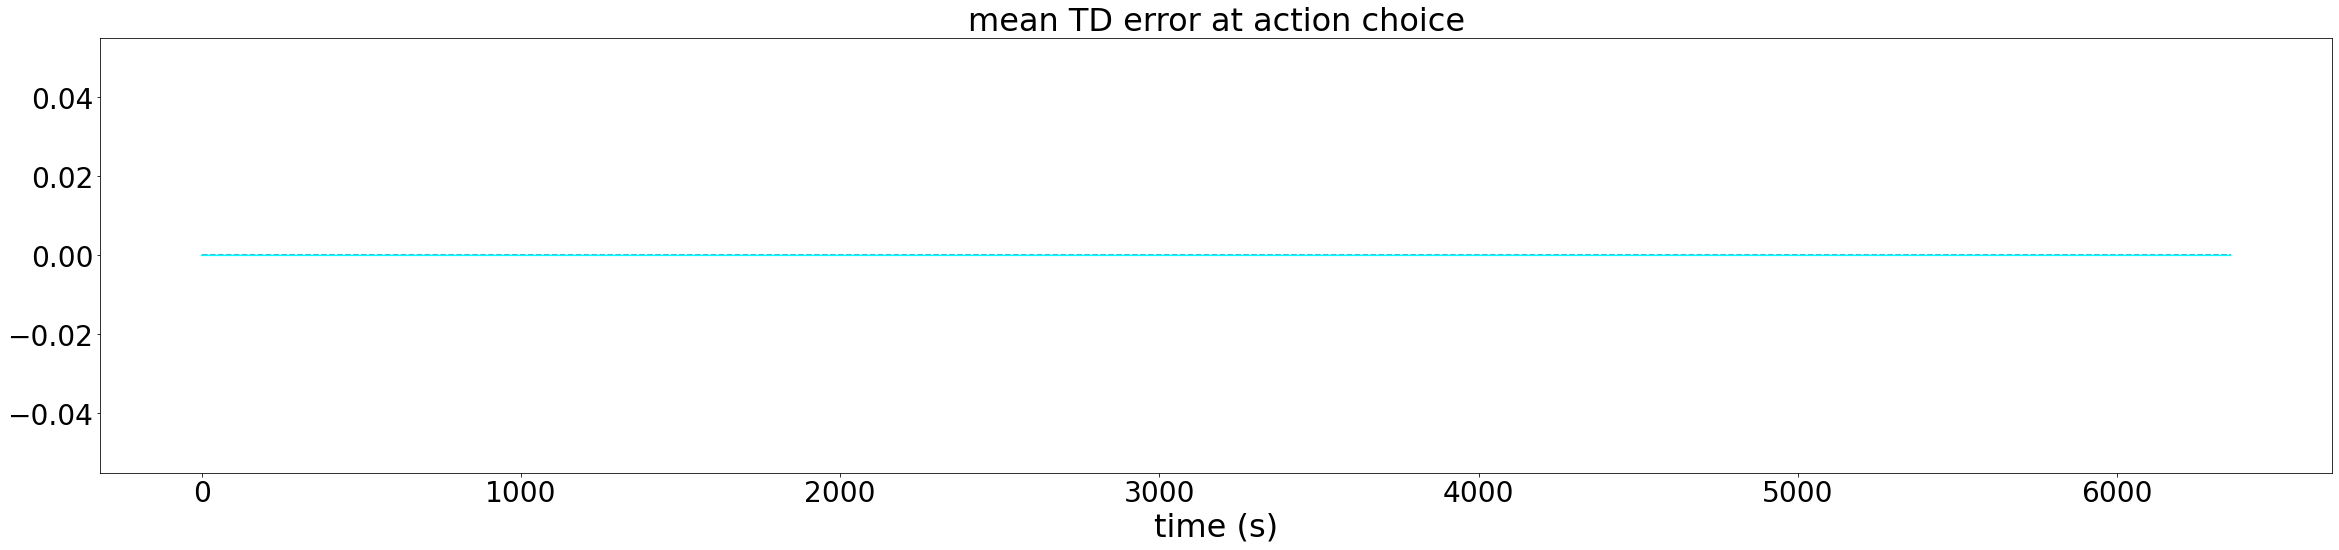

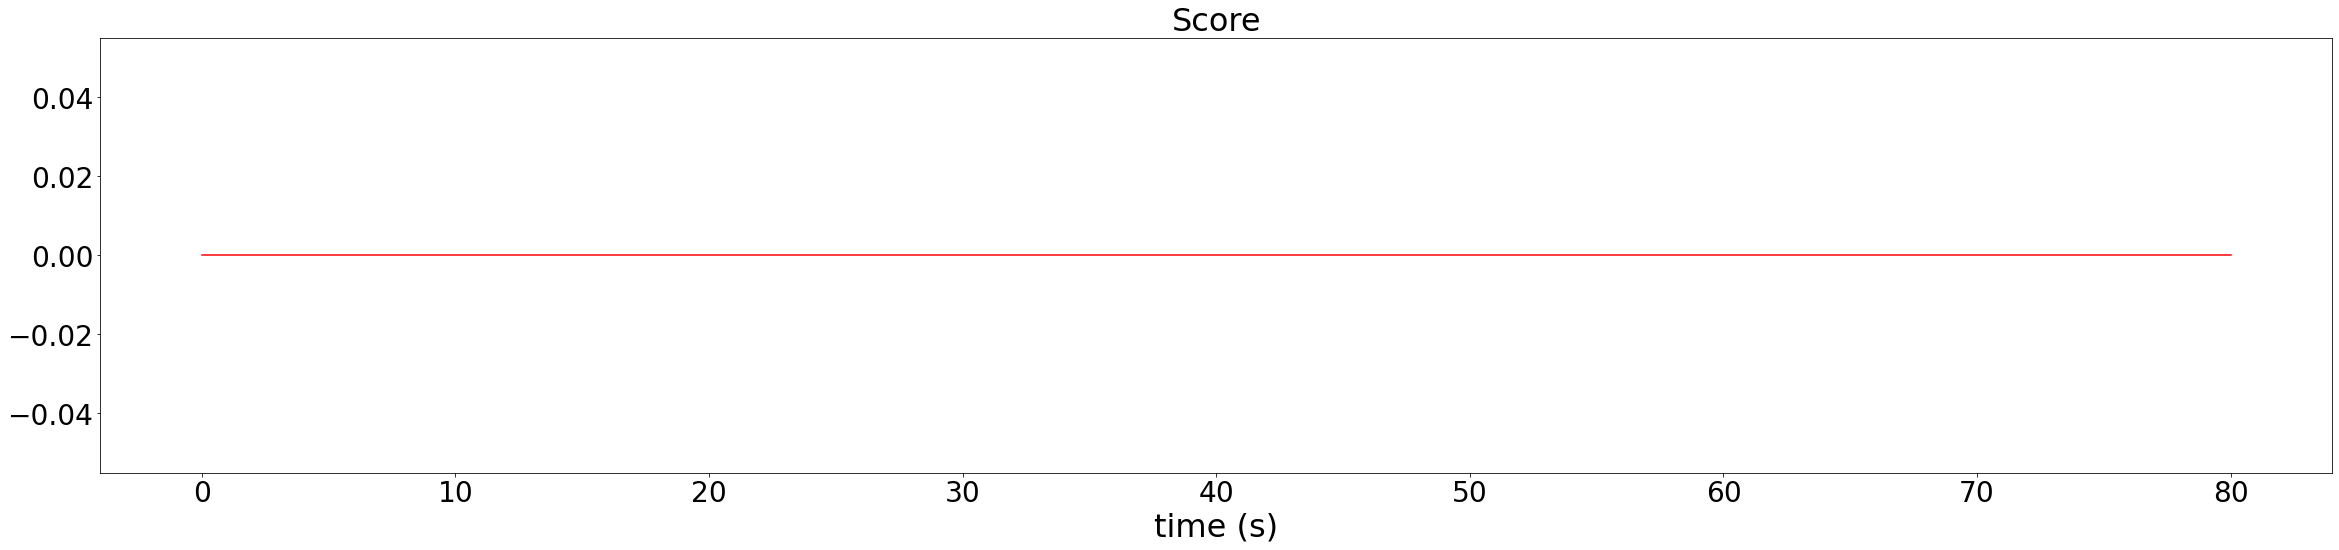

In [4]:
reward = np.array(spinet.state["learning_data"]["reward"])
value = np.array(spinet.state["learning_data"]["value"])
value_dot = np.array(spinet.state["learning_data"]["valueDot"])
td_error = np.array(spinet.state["learning_data"]["tdError"])
score = np.array(spinet.state["learning_data"]["score"])
t = np.linspace(0, np.max(spinet.spikes[0]), reward.size) * 1e-6

plt.figure(figsize=(40, 8))
plt.title("Reward and value curves")
plt.xlabel("time (s)")
plt.plot(t, reward, label="reward")
plt.plot(t, value, label="value")
plt.hlines(0, 0, t[-1], linestyles="dashed")
plt.legend()
plt.show()

plt.figure(figsize=(40, 8))
plt.title("Value derivative")
plt.xlabel("time (s)")
plt.plot(t, value_dot, color="green", label="value_dot")
plt.hlines(0, 0, t[-1], linestyles="dashed")
plt.show()

plt.figure(figsize=(40, 8))
plt.title("TD error")
plt.xlabel("time (s)")
plt.plot(t, td_error, color="red", label="td_error")
plt.hlines(0, 0, t[-1], linestyles="dashed")
plt.show()

td_actions = []
for i in range(0, td_error.shape[0], 10):
    td_actions.append(np.mean(td_error[i:i+10]))

plt.figure(figsize=(40, 8))
plt.title("mean TD error at action choice")
plt.xlabel("time (s)")
plt.plot(td_actions, color="cyan", label="td_error")
plt.hlines(0, 0, i/10, linestyles="dashed")
plt.show()

plt.figure(figsize=(40, 8))
plt.title("Score")
plt.xlabel("time (s)")
plt.plot(10*np.arange(0, score.shape[0]), score, color="red", label="td_error")
plt.show()

### Policy plot

In [5]:
actions = np.array(spinet.state["learning_data"]["action"])
exploration = np.array(spinet.state["learning_data"]["exploration"])

t = np.arange(0, 10*actions.size, 10)

classes = ["Left", "None", "Right"]
markers = ["s", "o"]

plt.figure(figsize=(40, 8))
plt.title("Actions")
plt.xlabel("time (s)")

plt.scatter(t[exploration == 0], np.zeros_like(t)[exploration == 0], c=actions[exploration == 0], marker='1', linewidths=15)
plt.scatter(t[exploration == 1], np.zeros_like(t)[exploration == 1], c=actions[exploration == 1], marker='s', linewidths=15)

plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

KeyError: 'action'

## Network weights

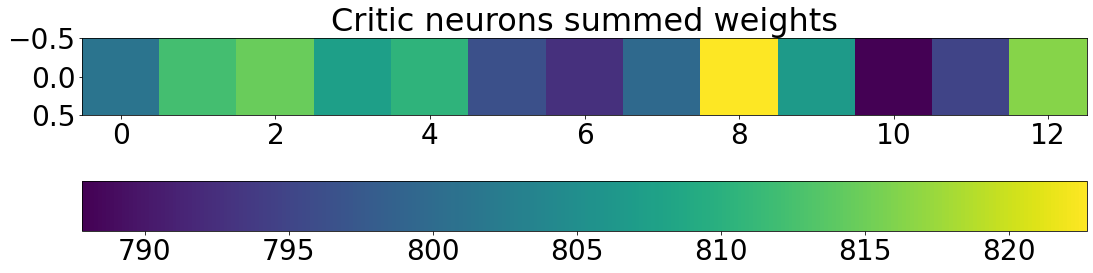

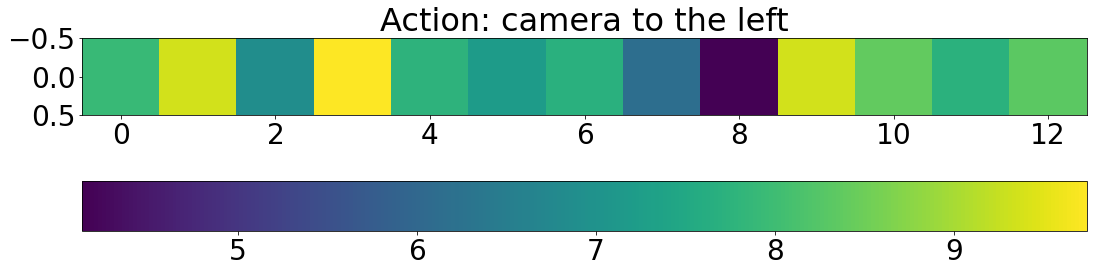

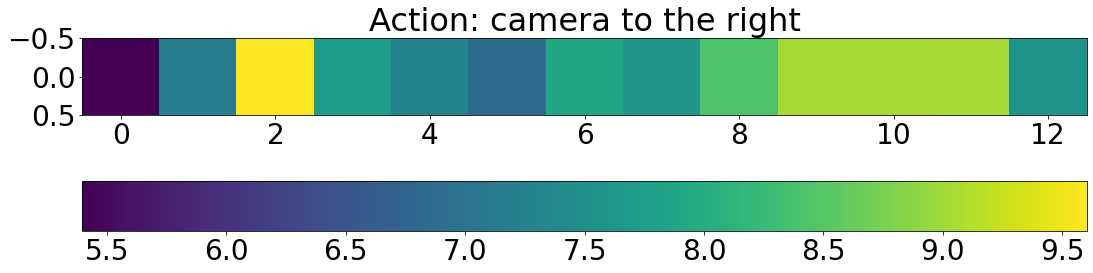

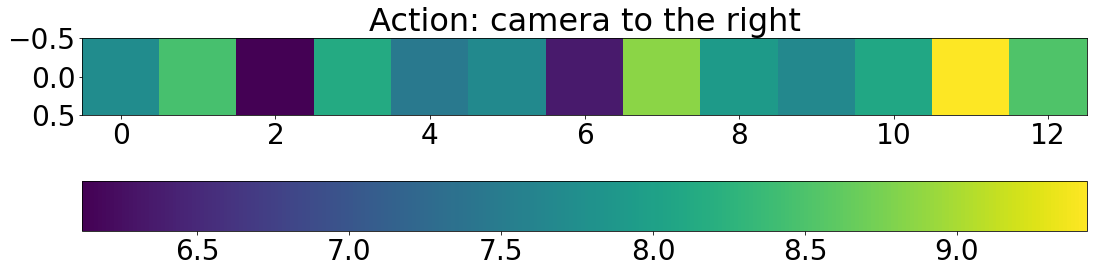

In [6]:
w = np.zeros((spinet.neurons[2][0].weights.shape[0], spinet.neurons[2][0].weights.shape[1]))
for neuron in spinet.neurons[2]:
    w += np.sum(neuron.weights, axis=2)
plt.figure(figsize=(18, 8))
plt.title("Critic neurons summed weights")
plt.imshow(w.T)
plt.colorbar(orientation="horizontal")
plt.show()

for i, neuron in enumerate(spinet.neurons[3]):
    plt.figure(figsize=(18, 8))
    if i == 0:
        plt.title("Action: camera to the left")
    else:
        plt.title("Action: camera to the right")   
    plt.imshow(np.sum(neuron.weights, axis=2).T)
    plt.colorbar(orientation="horizontal")
    plt.show()

## Spike rate information

We display here information about each layer spiking activity, in the form of a spike rate histogram (distribution of the number of spikes for all the neurons in the layer) and the spike rate variation over time (We count the number of spikes whithin a chosen time bin).

Layer 1, nb neurons = 7168:


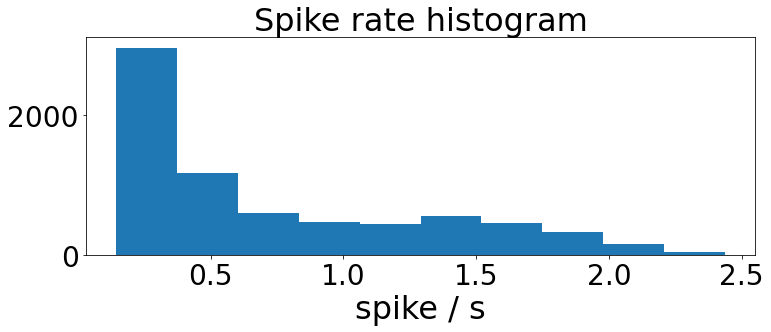

Layer 2, nb neurons = 208:


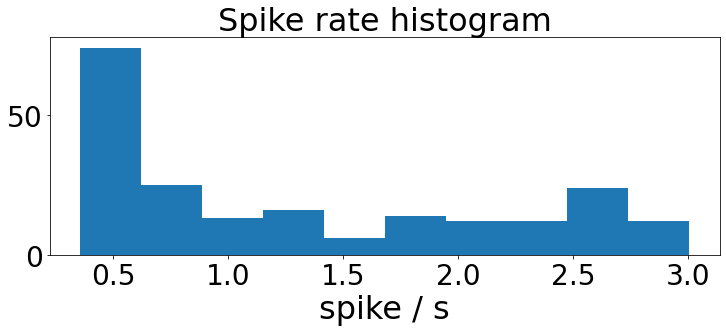

Layer 3, nb neurons = 100:


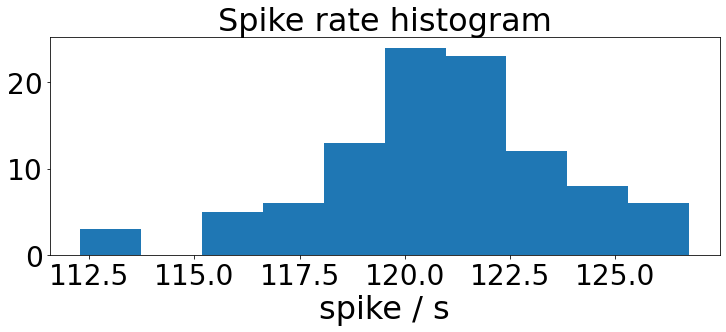

Layer 4, nb neurons = 2:


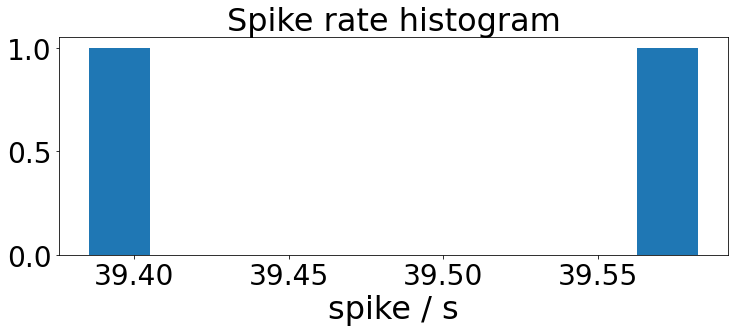

In [6]:
for layer, layer_spike_train in enumerate(spinet.spikes):
    print("Layer " + str(layer+1) + ", nb neurons = " + str(layer_spike_train.shape[0]) + ":")
    spike_rate_histogram(layer_spike_train)

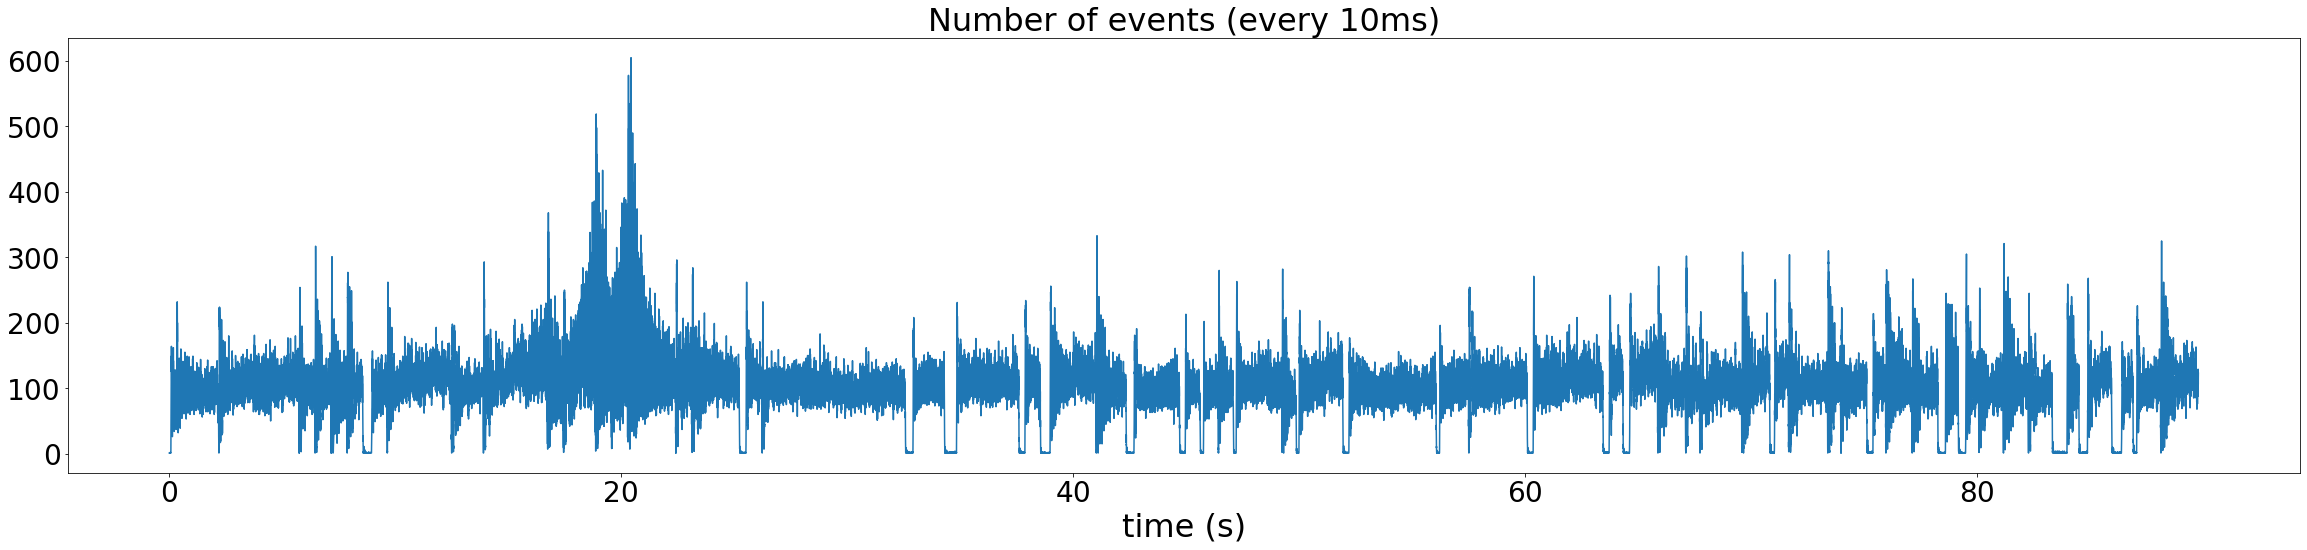

Layer 1, nb neurons = 7168:


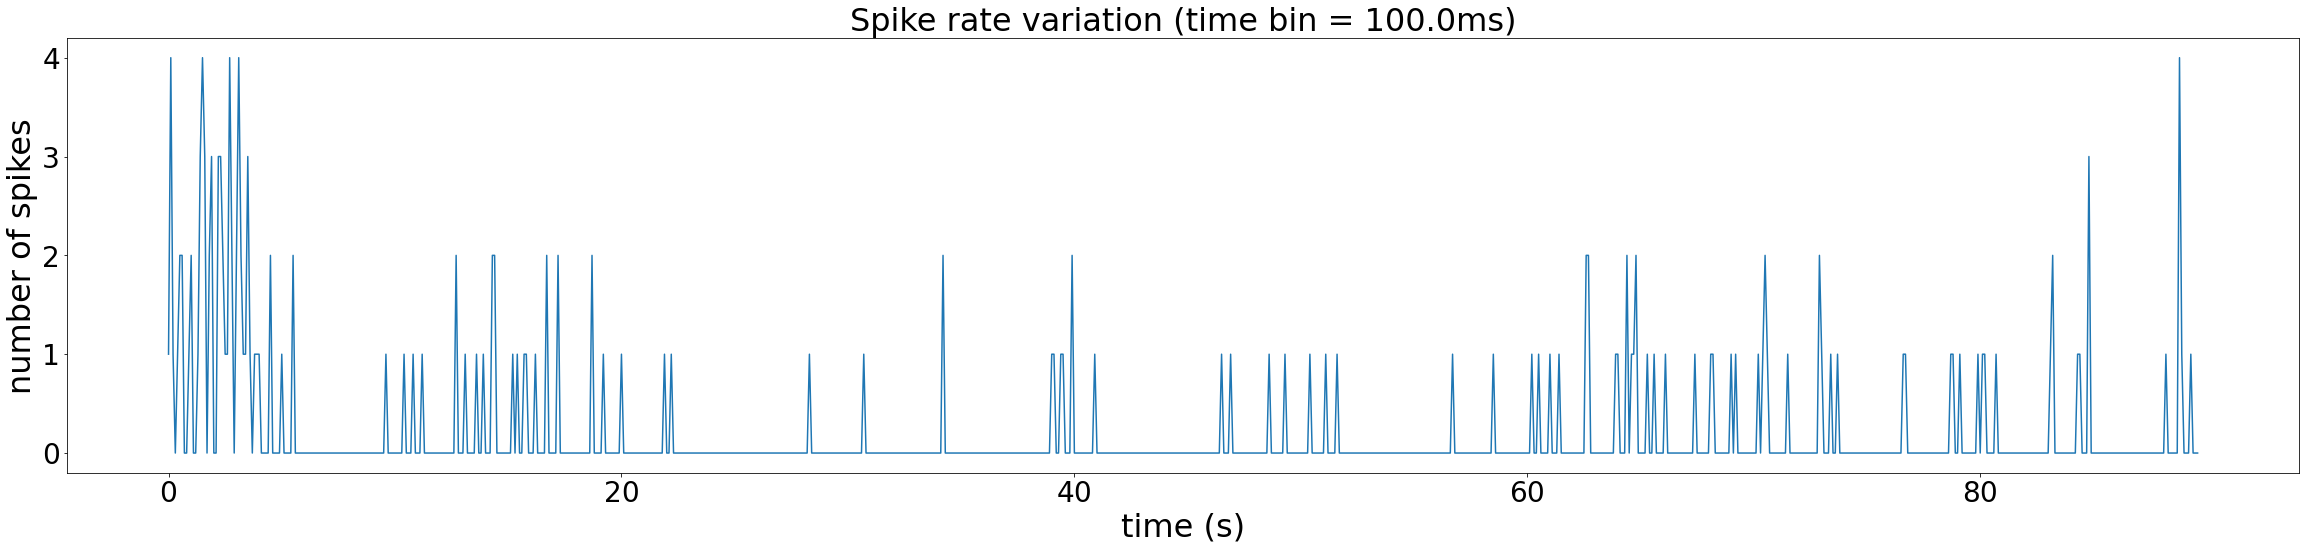

AttributeError: 'list' object has no attribute 'shape'

In [10]:
nb_events = np.array(spinet.state["learning_data"]["nbEvents"])[:-1]
t = np.linspace(0, np.max(spinet.spikes[0]), nb_events.size) * 1e-6
plt.figure(figsize=(40, 8))
plt.title("Number of events (every 10ms)")
plt.xlabel("time (s)")
plt.plot(t, nb_events)
plt.show()

for layer, layer_spike_train in enumerate(spinet.spikes[:-1]):
    print("Layer " + str(layer+1) + ", nb neurons = " + str(layer_spike_train.shape[0]) + ":")
    plot_spike_rate_variation(layer_spike_train, 1e5)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 63560 but corresponding boolean dimension is 63561

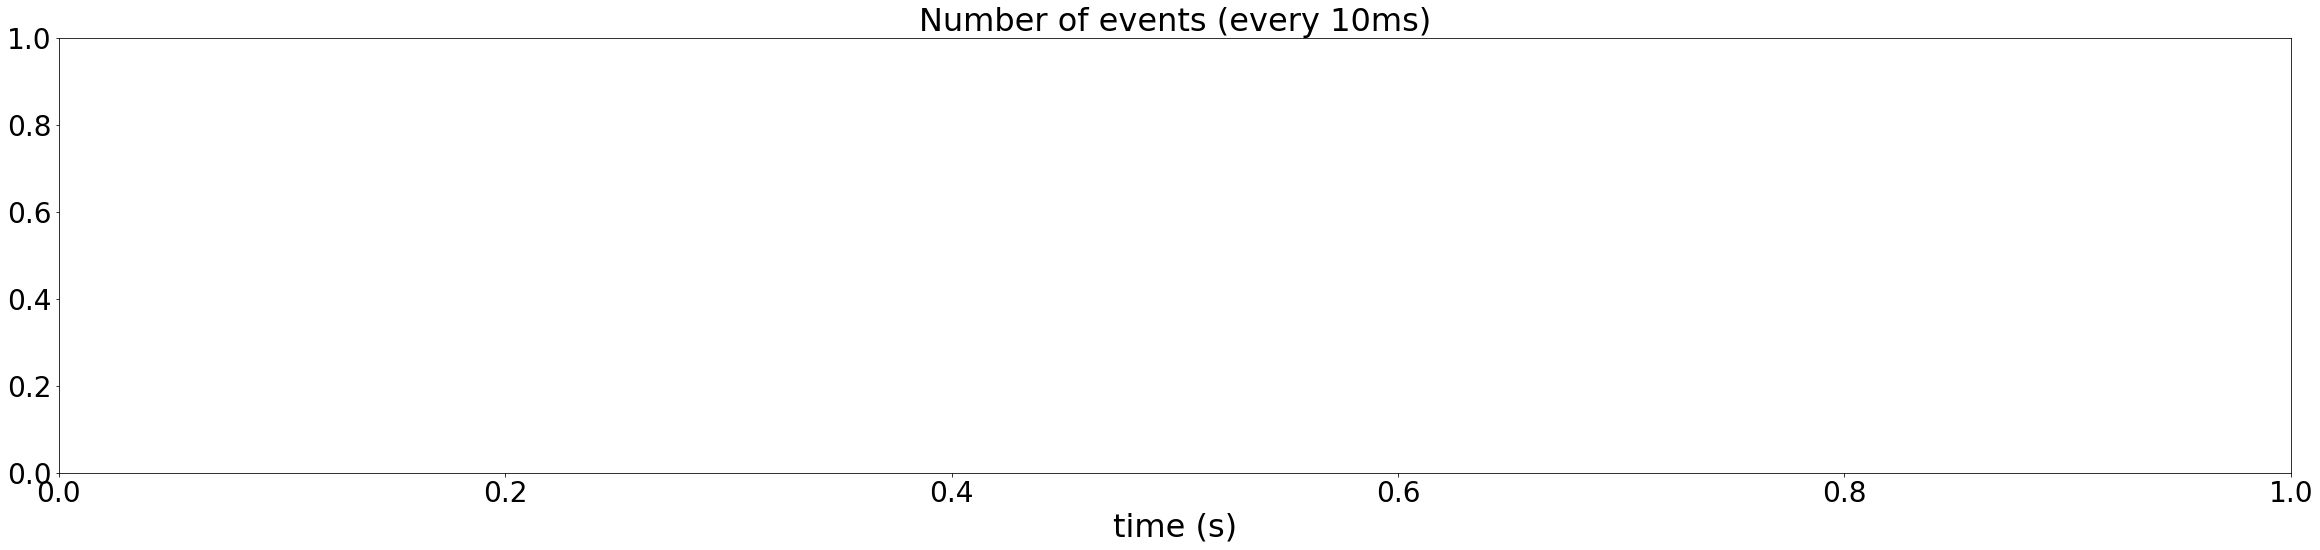

In [7]:
zoom_window = (22, 28) # s

nb_events = np.array(spinet.state["learning_data"]["nbEvents"])[:-1]
plt.figure(figsize=(40, 8))
plt.title("Number of events (every 10ms)")
plt.xlabel("time (s)")
plt.plot(t[(t > zoom_window[0]) & (t < zoom_window[1])], nb_events[(t > zoom_window[0]) & (t < zoom_window[1])], label="reward")
plt.legend()
plt.show()

for layer, layer_spike_train in enumerate(spinet.spikes[:-1]):
    signal, tstep = spike_rate_variation(layer_spike_train, 5e4)
    actions = np.arange(0, np.max(tstep), 100000) * 1e-6
    tstep = tstep[:-1] / 1e6

    plt.figure(figsize=(40, 8))
    plt.title("Layer " + str(layer+1) + ", nb neurons = " + str(layer_spike_train.shape[0]) + ", " + "time bin = 50ms" +
             "\nvertical lines = action choice")
    plt.xlabel("time (s)")
    plt.ylabel("number of spikes")
    plt.plot(tstep[(tstep > zoom_window[0]) & (tstep < zoom_window[1])], signal[(tstep > zoom_window[0]) & (tstep < zoom_window[1])])
    plt.vlines(actions[(actions > zoom_window[0]) & (actions < zoom_window[1])], 0, np.max(signal), linestyles="solid", alpha=0.1)
    plt.show()

## Spike plots

Layer 1, nb neurons = 7168:


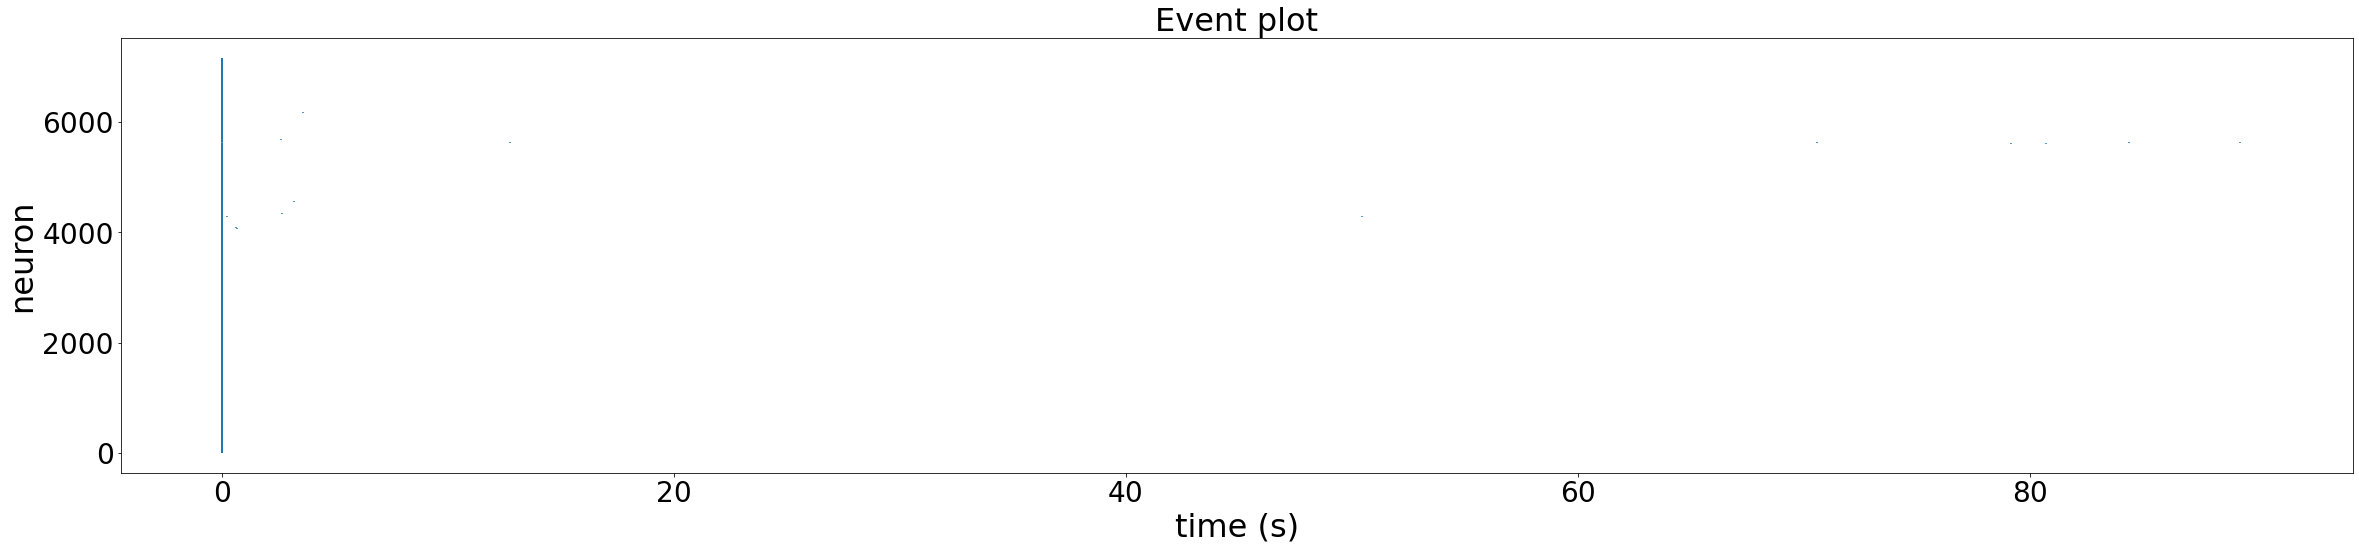

AttributeError: 'list' object has no attribute 'shape'

In [11]:
for layer, layer_spike_train in enumerate(spinet.spikes[:-1]):
    print("Layer " + str(layer+1) + ", nb neurons = " + str(layer_spike_train.shape[0]) + ":")
    plt.figure(figsize=(40, 8))
    plt.title("Event plot")
    plt.eventplot(layer_spike_train * 1e-6)
    plt.xlabel("time (s)")
    plt.ylabel("neuron")
    plt.show()

## Network configuration parameters

In [71]:
print("Network config:\n")
pprint.pprint(spinet.conf)
for layer in range(len(spinet.neurons)):
    print("\nLayer " + str(layer) + ":\n")
    pprint.pprint(spinet.neurons[layer][0].conf)

Network config:

{'V0': 0,
 'actionRate': 500,
 'decayRate': 0.01,
 'explorationFactor': 70,
 'interLayerConnections': [0, 0, 1, 1],
 'layerCellTypes': ['SimpleCell', 'ComplexCell', 'CriticCell', 'ActorCell'],
 'layerInhibitions': [True, True, False, False],
 'layerPatches': [[[33], [110], [0]],
                  [[0], [0], [0]],
                  [[0], [0], [0]],
                  [[0], [0], [0]]],
 'layerSizes': [[28, 4, 64], [13, 1, 16], [100, 1, 1], [2, 1, 1]],
 'minActionRate': 100,
 'nbCameras': 1,
 'neuron1Synapses': 1,
 'neuronOverlap': [[0, 0, 0], [2, 2, 0], [0, 0, 0], [0, 0, 0]],
 'neuronSizes': [[10, 10, 1], [4, 4, 64], [13, 1, 16], [13, 1, 16]],
 'nu': 0.5,
 'saveData': True,
 'sharingType': 'patch',
 'tauR': 1}

Layer 0:

{'ETA_INH': 20,
 'ETA_LTD': -0.0021,
 'ETA_LTP': 0.0077,
 'ETA_RP': 1,
 'ETA_SRA': 0.6,
 'ETA_TA': 0,
 'MIN_THRESH': 4,
 'NORM_FACTOR': 4,
 'STDP_LEARNING': True,
 'SYNAPSE_DELAY': 0,
 'TARGET_SPIKE_RATE': 0.75,
 'TAU_LTD': 14,
 'TAU_LTP': 7,
 'TAU_M': 18